In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm # progress bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pymongo import MongoClient
from sklearn.preprocessing import LabelEncoder

In [2]:
LISTE_MAJ = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
LISTE_MIN = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
LISTE_NBR = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

BATCH_SIZE = 128
EPOCHS = 10
ADD_NOM = "2_b" + str(BATCH_SIZE) + "_e" + str(EPOCHS)

In [3]:
# shape of the image : 50x50
# number of classes : 62
# number of train images : 487_227
# number of test images : 155_489
# number of validation images : 155_686

# Get Data
---

- Récupération des données de la base de données
- formattage des données
- répartition des données

In [4]:
# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/Scibio")  # Remplacez par l'URL de votre serveur MongoDB
db = client["Scribio"]  # Nom de la base de données
collection = db["Dataset"]  # Nom de la collection
# Temps : 0.0s

In [5]:
def fetch_data(repartition: str, nbr: int):
    query = {"Repartition": repartition}
    documents = collection.find(query)
    print(f"fetch {repartition} OK !!!")

    images = []
    labels = []
    types = []
    
    # Parcours et transformation des photos avec barre de progression 
    with tqdm(total=nbr, desc="Proccessing" , position=0, leave=True) as pbar:
        for doc in documents:
            images.append(np.array(doc["Tableau_Pixels"], dtype=np.float32))
            labels.append(doc["Label"])
            try:
                types.append(doc["Type"])
            except:
                if doc["Label"] in LISTE_MAJ:
                    types.append("Maj")
                elif doc["Label"] in LISTE_MIN:
                    types.append("Min")
                elif doc["Label"] in LISTE_NBR:
                    types.append("Nbr")
                else:
                    types.append("Auc")
            pbar.update(1) # Mettre à jour la barre de progression
            
    # return np.array(images), np.array(labels, dtype=str)
    return pd.DataFrame({"Labels": labels, "Types": types, "Images": images})

In [6]:
# Recupération des données d'entrainement depuis la base de données
df_train = fetch_data("train", 487_227)
print(df_train.shape) # (487_227, 3)
df_train.head()
# Temps : 5m 45.0s (en premier)

fetch train OK !!!


Proccessing: 100%|██████████| 487227/487227 [04:58<00:00, 1632.07it/s]

(487227, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [7]:
# Mélanger les données d'entrainement
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head()
# Temps : 0.0s

,Labels,Types,Images
0,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,h,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,E,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# Recupération des données de test depuis la base de données
df_test = fetch_data("test", 155_489)
print(df_test.shape) # (155_489, 3)
df_test.head()
# Temps : 27min 17.5s (en deuxième)
# Temps : 7m 14.4s (en premier)

fetch test OK !!!


Proccessing: 100%|██████████| 155489/155489 [33:22<00:00, 77.65it/s]  

(155489, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
# Mélanger les données de test
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head()
# Temps : 

,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
# Recupération des données de validation depuis la base de données
df_validation = fetch_data("validation", 155_686)
print(df_validation.shape) # (, 3)
df_validation.head()
# Temps : 45m 59.1s (en troisème)

fetch validation OK !!!


Proccessing: 100%|██████████| 155686/155686 [45:13<00:00, 57.38it/s]  

(155686, 3)


,Labels,Types,Images
0,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 

In [11]:
# Mélanger les données d'entrainement
df_validation = df_validation.sample(frac=1).reset_index(drop=True)
df_validation.head()
# Temps : 0.0s

,Labels,Types,Images
0,h,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,i,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Y,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Données pour apprentissage du NN 'Get type'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get type' qui permettra de classé les images selon trois catégories :

- Majuscule
- Minuscule
- Nombre

In [12]:
X_train_types = np.array(df_train["Images"].tolist())
y_train_types = np.array(df_train["Types"].tolist())
X_test_types = np.array(df_test["Images"].tolist())
y_test_types = np.array(df_test["Types"].tolist())
X_validation_types = np.array(df_validation["Images"].tolist())
y_validation_types = np.array(df_validation["Types"].tolist())
# Temps : 11.8s

In [13]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_types = LabelEncoder()

y_train_types_2 = label_encoder_types.fit_transform(y_train_types)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_types_2 = label_encoder_types.transform(y_test_types)
y_validation_types_2 = label_encoder_types.transform(y_validation_types)

In [14]:
# Correspondance indices ↔ labels
correspondance_types = dict(enumerate(label_encoder_types.classes_))
print(correspondance_types)

# Liste des labels
labels_types = list(correspondance_types.values())
print(labels_types)

{0: 'Maj', 1: 'Min', 2: 'Nbr'}
['Maj', 'Min', 'Nbr']


In [15]:
# Afficher quelques informations
print(f"Taille de X_train_types: {X_train_types.shape}, y_train_types: {y_train_types.shape}, y_train_types_2: {y_train_types_2.shape}")
print(f"Taille de X_test_types: {X_test_types.shape}, y_test_types: {y_test_types.shape}, y_test_types_2: {y_test_types_2.shape}")
print(f"Taille de X_validation_types: {X_validation_types.shape}, y_validation_types: {y_validation_types.shape}, y_validation_types_2: {y_validation_types_2.shape}")

Taille de X_train_types: (487227, 2500), y_train_types: (487227,), y_train_types_2: (487227,)
Taille de X_test_types: (155489, 2500), y_test_types: (155489,), y_test_types_2: (155489,)
Taille de X_validation_types: (155686, 2500), y_validation_types: (155686,), y_validation_types_2: (155686,)


### Données pour apprentissage du NN 'Get Maj'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Maj' qui permettra de classé les images selon la lettre majuscule qui y est representée.

In [16]:
df_train_Maj = df_train[df_train["Types"] == "Maj"]
print(df_train_Maj.shape) # (, 3)
df_train_Maj.head()
# Temps : 

(150341, 3)


,Labels,Types,Images
0,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,E,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,C,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
df_test_Maj = df_test[df_test["Types"] == "Maj"]
print(df_test_Maj.shape) # (, 3)
df_test_Maj.head()
# Temps :

(43121, 3)


,Labels,Types,Images
10,P,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,A,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
15,V,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,I,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
24,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [18]:
df_validation_Maj = df_validation[df_validation["Types"] == "Maj"]
print(df_validation_Maj.shape) # (, 3)
df_validation_Maj.head()
# Temps :

(43250, 3)


,Labels,Types,Images
4,Y,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,B,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,N,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
17,U,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
20,O,Maj,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [19]:
X_train_Maj = np.array(df_train_Maj["Images"].tolist())
y_train_Maj = np.array(df_train_Maj["Labels"].tolist())
X_test_Maj = np.array(df_test_Maj["Images"].tolist())
y_test_Maj = np.array(df_test_Maj["Labels"].tolist())
X_validation_Maj = np.array(df_validation_Maj["Images"].tolist())
y_validation_Maj = np.array(df_validation_Maj["Labels"].tolist())
# Temps : 

In [20]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Maj = LabelEncoder()

y_train_Maj_2 = label_encoder_Maj.fit_transform(y_train_Maj)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Maj_2 = label_encoder_Maj.transform(y_test_Maj)
y_validation_Maj_2 = label_encoder_Maj.transform(y_validation_Maj)

In [21]:
# Correspondance indices ↔ labels
correspondance_Maj = dict(enumerate(label_encoder_Maj.classes_))
print(correspondance_Maj)

# Liste des labels
labels_Maj = list(correspondance_Maj.values())
print(labels_Maj)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [22]:
# Afficher quelques informations
print(f"Taille de X_train_Maj: {X_train_Maj.shape}, y_train_Maj: {y_train_Maj.shape}, y_train_Maj_2: {y_train_Maj_2.shape}")
print(f"Taille de X_test_Maj: {X_test_Maj.shape}, y_test_Maj: {y_test_Maj.shape}, y_test_Maj_2: {y_test_Maj_2.shape}")
print(f"Taille de X_validation_Maj: {X_validation_Maj.shape}, y_validation_Maj: {y_validation_Maj.shape}, y_validation_Maj_2: {y_validation_Maj_2.shape}")

Taille de X_train_Maj: (150341, 2500), y_train_Maj: (150341,), y_train_Maj_2: (150341,)
Taille de X_test_Maj: (43121, 2500), y_test_Maj: (43121,), y_test_Maj_2: (43121,)
Taille de X_validation_Maj: (43250, 2500), y_validation_Maj: (43250,), y_validation_Maj_2: (43250,)


### Données pour apprentissage du NN 'Get Min'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Min' qui permettra de classé les images selon la lettre minuscule qui y est representée.

In [23]:
df_train_Min = df_train[df_train["Types"] == "Min"]
print(df_train_Min.shape) # (, 3)
df_train_Min.head()
# Temps : 

(111713, 3)


,Labels,Types,Images
3,h,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,w,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
10,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21,g,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [24]:
df_test_Min = df_test[df_test["Types"] == "Min"]
print(df_test_Min.shape) # (, 3)
df_test_Min.head()
# Temps :

(37358, 3)


,Labels,Types,Images
1,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,k,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18,t,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [25]:
df_validation_Min = df_validation[df_validation["Types"] == "Min"]
print(df_validation_Min.shape) # (, 3)
df_validation_Min.head()
# Temps :

(37374, 3)


,Labels,Types,Images
0,h,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,i,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,e,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,a,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
13,r,Min,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
X_train_Min = np.array(df_train_Min["Images"].tolist())
y_train_Min = np.array(df_train_Min["Labels"].tolist())
X_test_Min = np.array(df_test_Min["Images"].tolist())
y_test_Min = np.array(df_test_Min["Labels"].tolist())
X_validation_Min = np.array(df_validation_Min["Images"].tolist())
y_validation_Min = np.array(df_validation_Min["Labels"].tolist())
# Temps : 1.3s

In [27]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Min = LabelEncoder()

y_train_Min_2 = label_encoder_Min.fit_transform(y_train_Min)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Min_2 = label_encoder_Min.transform(y_test_Min)
y_validation_Min_2 = label_encoder_Min.transform(y_validation_Min)

In [28]:
# Correspondance indices ↔ labels
correspondance_Min = dict(enumerate(label_encoder_Min.classes_))
print(correspondance_Min)

# Liste des labels
labels_Min = list(correspondance_Min.values())
print(labels_Min)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [29]:
# Afficher quelques informations
print(f"Taille de X_train_Min: {X_train_Min.shape}, y_train_Min: {y_train_Min.shape}, y_train_Min_2: {y_train_Min_2.shape}")
print(f"Taille de X_test_Min: {X_test_Min.shape}, y_test_Min: {y_test_Min.shape}, y_test_Min_2: {y_test_Min_2.shape}")
print(f"Taille de X_validation_Min: {X_validation_Min.shape}, y_validation_Min: {y_validation_Min.shape}, y_validation_Min_2: {y_validation_Min_2.shape}")

Taille de X_train_Min: (111713, 2500), y_train_Min: (111713,), y_train_Min_2: (111713,)
Taille de X_test_Min: (37358, 2500), y_test_Min: (37358,), y_test_Min_2: (37358,)
Taille de X_validation_Min: (37374, 2500), y_validation_Min: (37374,), y_validation_Min_2: (37374,)


### Données pour apprentissage du NN 'Get Nbr'
---

Préparation des données pour l'entrainement du réseau de neurones 'Get Nbr' qui permettra de classé les images selon le chiffre qui y est représenté.

In [30]:
df_train_Nbr = df_train[df_train["Types"] == "Nbr"]
print(df_train_Nbr.shape) # (, 3)
df_train_Nbr.head()
# Temps : 

(225173, 3)


,Labels,Types,Images
2,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
12,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14,9,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [31]:
df_test_Nbr = df_test[df_test["Types"] == "Nbr"]
print(df_test_Nbr.shape) # (, 3)
df_test_Nbr.head()
# Temps : 

(75010, 3)


,Labels,Types,Images
0,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,4,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [32]:
df_validation_Nbr = df_validation[df_validation["Types"] == "Nbr"]
print(df_validation_Nbr.shape) # (, 3)
df_validation_Nbr.head()
# Temps : 

(75062, 3)


,Labels,Types,Images
1,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,2,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,1,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,7,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,5,Nbr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
X_train_Nbr = np.array(df_train_Nbr["Images"].tolist())
y_train_Nbr = np.array(df_train_Nbr["Labels"].tolist())
X_test_Nbr = np.array(df_test_Nbr["Images"].tolist())
y_test_Nbr = np.array(df_test_Nbr["Labels"].tolist())
X_validation_Nbr = np.array(df_validation_Nbr["Images"].tolist())
y_validation_Nbr = np.array(df_validation_Nbr["Labels"].tolist())
# Temps : 9.1s

In [34]:
# Conversion des étiquettes en indices (si nécessaire)
label_encoder_Nbr = LabelEncoder()

y_train_Nbr_2 = label_encoder_Nbr.fit_transform(y_train_Nbr)  # Convertit les étiquettes (lettres/nombres) en indices numériques (nombre) (str => int)
y_test_Nbr_2 = label_encoder_Nbr.transform(y_test_Nbr)
y_validation_Nbr_2 = label_encoder_Nbr.transform(y_validation_Nbr)

In [35]:
# Correspondance indices ↔ labels
correspondance_Nbr = dict(enumerate(label_encoder_Nbr.classes_))
print(correspondance_Nbr)

# Liste des labels
labels_Nbr = list(correspondance_Nbr.values())
print(labels_Nbr)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [36]:
# Afficher quelques informations
print(f"Taille de X_train_Nbr: {X_train_Nbr.shape}, y_train_Nbr: {y_train_Nbr.shape}, y_train_Nbr_2: {y_train_Nbr_2.shape}")
print(f"Taille de X_test_Nbr: {X_test_Nbr.shape}, y_test_Nbr: {y_test_Nbr.shape}, y_test_Nbr_2: {y_test_Nbr_2.shape}")
print(f"Taille de X_validation_Nbr: {X_validation_Nbr.shape}, y_validation_Nbr: {y_validation_Nbr.shape}, y_validation_Nbr_2: {y_validation_Nbr_2.shape}")

Taille de X_train_Nbr: (225173, 2500), y_train_Nbr: (225173,), y_train_Nbr_2: (225173,)
Taille de X_test_Nbr: (75010, 2500), y_test_Nbr: (75010,), y_test_Nbr_2: (75010,)
Taille de X_validation_Nbr: (75062, 2500), y_validation_Nbr: (75062,), y_validation_Nbr_2: (75062,)


# Get Type (NN)
---

Modèle ...

In [37]:
# Reseau de neurones
model_get_type = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(1750, activation='relu'),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(3, activation='softmax') # output layer : 3 neurones (Maj, Min, Nbr) -> softmax : sortie à 3 classes
])

model_get_type.compile(
    optimizer='adam', # optimizer : Adam avec learning rate de 0.0001
    loss='sparse_categorical_crossentropy', # loss : sparse_categorical_crossentropy pour la classification
    metrics=['accuracy'] # metrics : accuracy pour évaluer la performance du modèle
)

In [38]:
model_get_type.fit(
    X_train_types, 
    y_train_types_2, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_data=(
        X_validation_types, 
        y_validation_types_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.8618
# loss : 0.3311
# Temps : 16m 33.5s

# Batch 64
# accuracy : 0.8644
# loss : 0.3228
# Temps : 8m 41s

# Batch 128
# accuracy : 0.8654
# loss : 0.3209
# Temps : 4m 35.4s

# Batch 256
# accuracy : 0.8644
# loss : 0.3220
# Temps : 2m 46.5s

Epoch 1/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 474s 31ms/step - accuracy: 0.7704 - loss: 0.5441 - val_accuracy: 0.8220 - val_loss: 0.4303
Epoch 2/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 464s 30ms/step - accuracy: 0.8320 - loss: 0.4083 - val_accuracy: 0.8254 - val_loss: 0.4203
Epoch 3/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 490s 32ms/step - accuracy: 0.8421 - loss: 0.3806 - val_accuracy: 0.8346 - val_loss: 0.4012
Epoch 4/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 489s 32ms/step - accuracy: 0.8468 - loss: 0.3673 - val_accuracy: 0.8372 - val_loss: 0.3971
Epoch 5/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 486s 32ms/step - accuracy: 0.8520 - loss: 0.3565 - val_accuracy: 0.8382 - val_loss: 0.3980
Epoch 6/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 498s 33ms/step - accuracy: 0.8546 - loss: 0.3494 - val_accuracy: 0.8360 - val_loss: 0.4016
Epoch 7/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 503s 33ms/step - accuracy: 0.8587 - loss: 0.3401 - val_accuracy: 0.8405 - val_loss: 0.4032
Epoch 8/10
15226/15226 ━━━━━━━━━━━━━━━━━━━━ 480s 32ms/s

In [39]:
test_loss_type, test_acc_type = model_get_type.evaluate(X_test_types, y_test_types_2)
print(f"Test accuracy : {test_acc_type}") # Test accuracy : 
print(f"Test loss : {test_loss_type}") # Test loss : 
# Temps : 8.3s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8427 - loss: 0.4143
Test accuracy : 0.8420531153678894
Test loss : 0.4206249415874481


In [40]:
# Sauvegarder le modèle
model_get_type.save("../models/Get_type_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [41]:
y_predicted_types = model_get_type.predict(X_test_types)
y_predicted_types[1]
# Temps : 7.2s

4860/4860 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step


array([1.2727101e-06, 9.9999869e-01, 1.3928408e-11], dtype=float32)

In [42]:
np.argmax(y_predicted_types[1])

1

In [43]:
# y_predicted_labels1 = np.array([correspondance_types[np.argmax(i)] for i in y_predicted_types])
y_predicted_labels_types = [np.argmax(i) for i in y_predicted_types]
y_predicted_labels_types[:5]

[2, 1, 2, 2, 1]

In [44]:
y_test_types_2[:5]

array([2, 1, 2, 2, 1])

Text(95.72222222222221, 0.5, 'Truth')

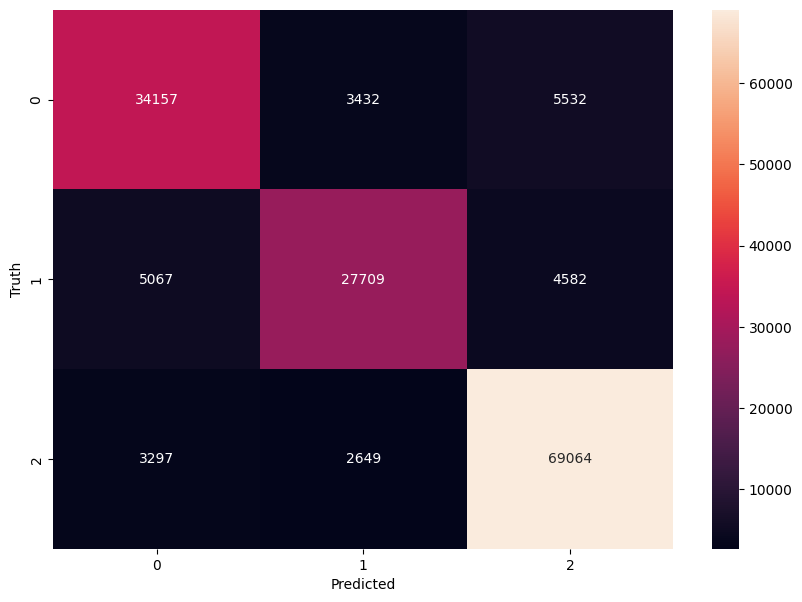

In [45]:
# Matrice de confusion
cm_types = tf.math.confusion_matrix(labels=y_test_types_2, predictions=y_predicted_labels_types)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_types, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Maj (NN)
---

Modèle ...

In [46]:
model_get_maj = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(1750, activation='relu'),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_maj.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [47]:
model_get_maj.fit(
    X_train_Maj, 
    y_train_Maj_2, 
    epochs=EPOCHS, 
    batch_size=128, 
    validation_data=(
        X_validation_Maj, 
        y_validation_Maj_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9508
# loss : 0.1701
# Temps : 5m 17.7s

# Batch 64
# accuracy : 0.9522
# loss : 0.1632
# Temps : 2m 18.6s

# Batch 128
# accuracy : 0.9558
# loss : 0.1531
# Temps : 1m 19.8s

# Batch 256
# accuracy : 0.9527
# loss : 0.1621
# Temps : 51.7s

Epoch 1/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.8013 - loss: 0.7163 - val_accuracy: 0.9171 - val_loss: 0.3139
Epoch 2/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9233 - loss: 0.2752 - val_accuracy: 0.9200 - val_loss: 0.2974
Epoch 3/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9343 - loss: 0.2313 - val_accuracy: 0.9303 - val_loss: 0.2629
Epoch 4/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9403 - loss: 0.2097 - val_accuracy: 0.9268 - val_loss: 0.2780
Epoch 5/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9428 - loss: 0.1966 - val_accuracy: 0.9336 - val_loss: 0.2630
Epoch 6/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9483 - loss: 0.1795 - val_accuracy: 0.9341 - val_loss: 0.2622
Epoch 7/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9504 - loss: 0.1730 - val_accuracy: 0.9327 - val_loss: 0.2776
Epoch 8/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30ms/step - accuracy: 0.9517 -

In [48]:
test_loss_maj, test_acc_maj = model_get_maj.evaluate(X_test_Maj, y_test_Maj_2)
print(f"Test accuracy : {test_acc_maj}") # Test accuracy : 
print(f"Test loss : {test_loss_maj}") # Test loss : 
# Temps : 1.9s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9356 - loss: 0.2853
Test accuracy : 0.9352519512176514
Test loss : 0.2858487069606781


In [49]:
# Sauvegarder le modèle
model_get_maj.save("../models/Get_Maj_v" + ADD_NOM + ".keras")  # Format HDF5 (.h5)

In [50]:
y_predicted_Maj = model_get_maj.predict(X_test_Maj)
y_predicted_Maj[1]
# Temps 1.8s

1348/1348 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


array([9.9999934e-01, 7.7308720e-01, 3.5535383e-01, 9.9393952e-01,
       8.8625532e-01, 8.9389563e-01, 5.9978044e-01, 9.9412745e-01,
       2.0962171e-01, 3.3624984e-02, 4.3295968e-02, 4.3806973e-01,
       6.0872602e-01, 9.7811294e-01, 6.6230005e-01, 9.8547041e-01,
       3.8519187e-03, 1.8753965e-01, 2.7242338e-03, 3.3365086e-02,
       4.1397437e-04, 7.9703750e-04, 5.4788470e-01, 2.4486220e-02,
       3.7600882e-02, 1.6414608e-05], dtype=float32)

In [51]:
np.argmax(y_predicted_Maj[1])

0

In [52]:
# y_predicted_labels_Maj = [correspondance_Maj[np.argmax(i)] for i in y_predicted_Maj]
y_predicted_labels_Maj = [np.argmax(i) for i in y_predicted_Maj]
y_predicted_labels_Maj[:5]

[15, 0, 21, 8, 14]

Text(95.72222222222221, 0.5, 'Truth')

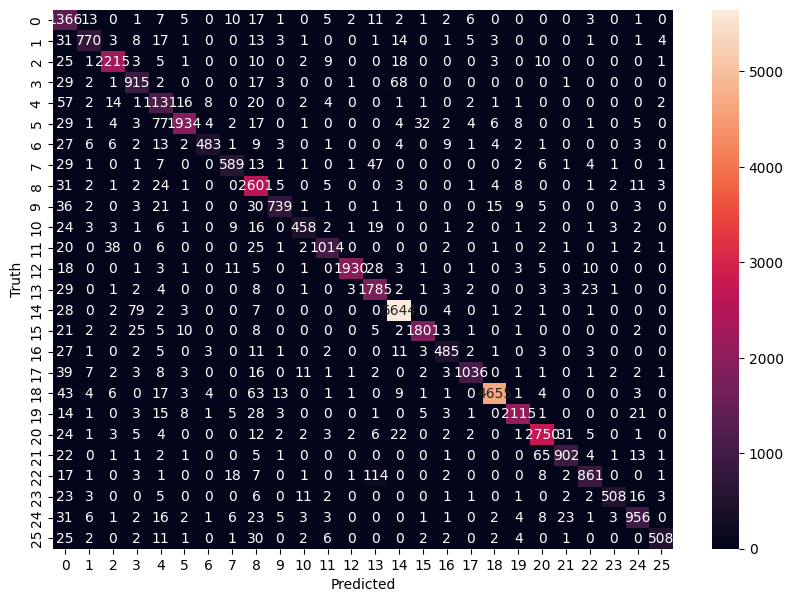

In [53]:
# Matrice de confusion
cm_Maj = tf.math.confusion_matrix(labels=y_test_Maj_2, predictions=y_predicted_labels_Maj)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Maj, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Min (NN)
---

Modèle ...

In [54]:
model_get_min = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(1750, activation='relu'),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(26, activation='sigmoid') # output layer : 26 neurones (A-Z)
])

model_get_min.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
model_get_min.fit(
    X_train_Min, 
    y_train_Min_2, 
    epochs=EPOCHS, 
    batch_size=128, 
    validation_data=(
        X_validation_Min, 
        y_validation_Min_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9293
# loss : 0.2193
# Temps : 2m 45.3s

# Batch 64
# accuracy : 0.9328
# loss : 0.2042
# Temps : 2m 2.7s

# Batch 128
# accuracy : 0.9332
# loss : 0.2038
# Temps : 58.4s

# Batch 256
# accuracy : 0.9338
# loss : 0.2036
# Temps : 38.3s

Epoch 1/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.7831 - loss: 0.7784 - val_accuracy: 0.8790 - val_loss: 0.4012
Epoch 2/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.8917 - loss: 0.3579 - val_accuracy: 0.8913 - val_loss: 0.3649
Epoch 3/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9046 - loss: 0.3115 - val_accuracy: 0.8970 - val_loss: 0.3508
Epoch 4/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9140 - loss: 0.2789 - val_accuracy: 0.9003 - val_loss: 0.3457
Epoch 5/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - accuracy: 0.9185 - loss: 0.2544 - val_accuracy: 0.8980 - val_loss: 0.3569
Epoch 6/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9245 - loss: 0.2383 - val_accuracy: 0.9015 - val_loss: 0.3499
Epoch 7/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9273 - loss: 0.2265 - val_accuracy: 0.9026 - val_loss: 0.3516
Epoch 8/10
873/873 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.9315 - loss: 0.2135 - 

In [56]:
test_loss_min, test_acc_min = model_get_min.evaluate(X_test_Min, y_test_Min_2)
print(f"Test accuracy : {test_acc_min}") # Test accuracy : 
print(f"Test loss : {test_loss_min}") # Test loss : 
# Temps : 

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9064 - loss: 0.3524
Test accuracy : 0.9053750038146973
Test loss : 0.3557049036026001


In [57]:
# Sauvegarder le modèle
model_get_min.save("../models/Get_Min_v" + ADD_NOM + ".keras")  # Format keras (.keras)

In [58]:
y_predicted_Min = model_get_min.predict(X_test_Min)
y_predicted_Min[1]

1168/1168 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


array([3.7943786e-01, 1.4323607e-03, 9.1954082e-01, 1.4593005e-04,
       6.7862546e-01, 8.1423724e-01, 2.5948825e-01, 3.8280867e-02,
       5.3159217e-04, 9.3061998e-03, 1.8773583e-03, 6.1412263e-01,
       1.7699229e-03, 7.5359094e-01, 2.6605953e-03, 8.3907443e-01,
       4.4839466e-03, 9.9999994e-01, 3.9724717e-01, 9.9751401e-01,
       4.5803140e-06, 2.6060769e-01, 1.5482088e-09, 1.5511469e-05,
       9.7040340e-02, 2.2374501e-05], dtype=float32)

In [59]:
# y_predicted_labels_Min = [correspondance_Min[np.argmax(i)] for i in y_predicted_Min]
y_predicted_labels_Min = [np.argmax(i) for i in y_predicted_Min]
y_predicted_labels_Min[:5]

[19, 17, 10, 19, 19]

Text(95.72222222222221, 0.5, 'Truth')

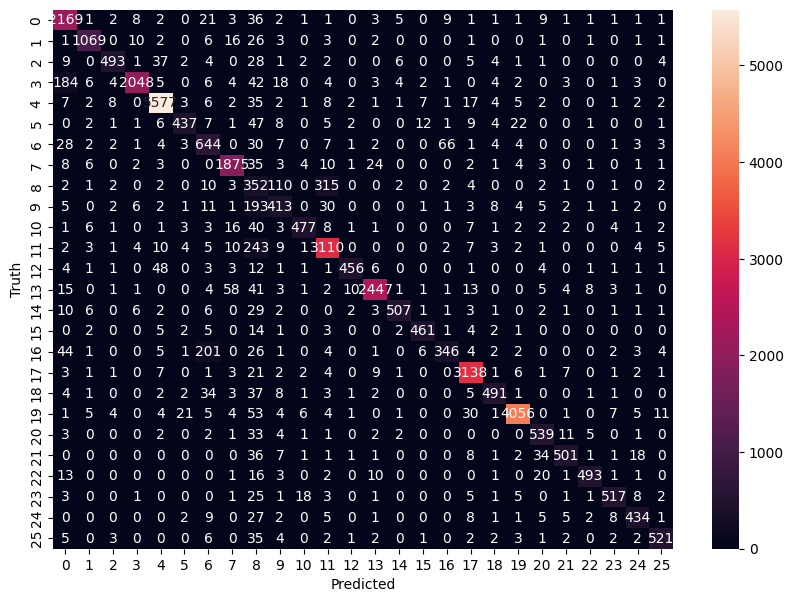

In [60]:
# Matrice de confusion
cm_Min = tf.math.confusion_matrix(labels=y_test_Min_2, predictions=y_predicted_labels_Min)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Min, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Get Nbr (NN)
---

Modèle ...

In [61]:
model_get_nbr = keras.Sequential([
    keras.layers.Input((2500,)), # input layer : 2500 neurones (50x50 pixels)
    keras.layers.Dense(1750, activation='relu'),
    keras.layers.Dense(1000, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='sigmoid') # output layer : 10 neurones (0-9)
])

model_get_nbr.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
model_get_nbr.fit(
    X_train_Nbr, 
    y_train_Nbr_2, 
    epochs=EPOCHS, 
    batch_size=128,
    validation_data=(
        X_validation_Nbr, 
        y_validation_Nbr_2
    ),
    verbose=1
)

# Batch 32
# accuracy : 0.9325
# loss : 0.1897
# Temps : 6m 16.0s

# Batch 64
# accuracy : 0.9347
# loss : 0.1844
# Temps : 4m 16.6s

# Batch 128
# accuracy : 0.9343
# loss : 0.1834
# Temps : 1m 59.6s

# Batch 256
# accuracy : 0.9342
# loss : 0.1825
# Temps : 1m 16.2s

Epoch 1/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 53s 30ms/step - accuracy: 0.8765 - loss: 0.3860 - val_accuracy: 0.9170 - val_loss: 0.2518
Epoch 2/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9210 - loss: 0.2352 - val_accuracy: 0.9224 - val_loss: 0.2258
Epoch 3/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.9254 - loss: 0.2170 - val_accuracy: 0.9241 - val_loss: 0.2272
Epoch 4/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9287 - loss: 0.2066 - val_accuracy: 0.9253 - val_loss: 0.2191
Epoch 5/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9294 - loss: 0.2024 - val_accuracy: 0.9278 - val_loss: 0.2150
Epoch 6/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9310 - loss: 0.1978 - val_accuracy: 0.9275 - val_loss: 0.2171
Epoch 7/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9325 - loss: 0.1913 - val_accuracy: 0.9281 - val_loss: 0.2158
Epoch 8/10
1760/1760 ━━━━━━━━━━━━━━━━━━━━ 51s 29ms/step - accuracy: 0.9338 -

In [63]:
test_loss_nbr, test_acc_nbr = model_get_nbr.evaluate(X_test_Nbr, y_test_Nbr_2)
print(f"Test accuracy : {test_acc_nbr}") # Test accuracy : 
print(f"Test loss : {test_loss_nbr}") # Test loss : 
# Temps : 3.0s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9247 - loss: 0.2256
Test accuracy : 0.9253299832344055
Test loss : 0.22489826381206512


In [64]:
# Sauvegarder le modèle
model_get_nbr.save("../models/Get_Nbr_v" + ADD_NOM + ".keras")  # Format keras (.keras)

In [65]:
y_predicted_Nbr = model_get_nbr.predict(X_test_Nbr)
y_predicted_Nbr[1]
# Temps : 3.4s

2345/2345 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


array([0.9999852 , 0.00764219, 0.9718231 , 0.07599138, 0.63383675,
       0.8662904 , 0.9781628 , 0.43026128, 0.9910955 , 0.99828786],
      dtype=float32)

In [66]:
# y_predicted_labels_Nbr = [correspondance_Nbr[np.argmax(i)] for i in y_predicted_Nbr]
y_predicted_labels_Nbr = [np.argmax(i) for i in y_predicted_Nbr]
y_predicted_labels_Nbr[:5]

[4, 0, 1, 5, 4]

Text(95.72222222222221, 0.5, 'Truth')

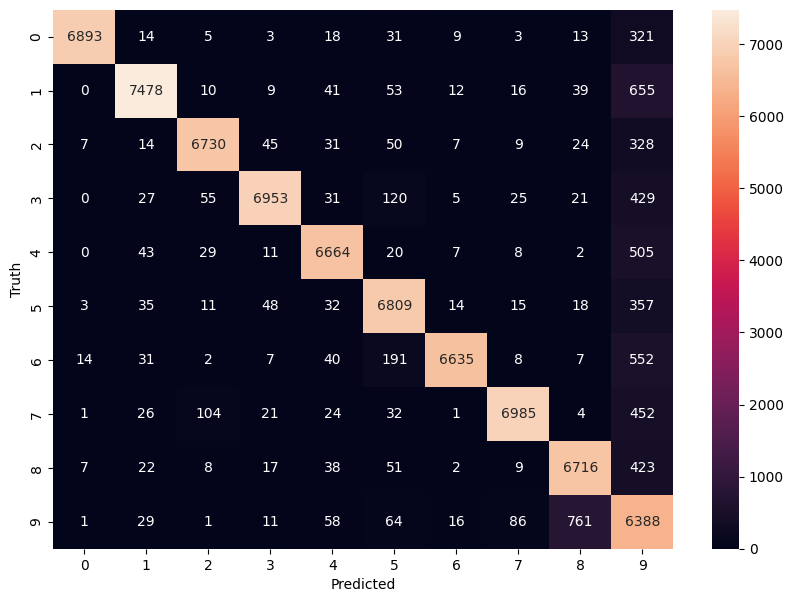

In [67]:
# Matrice de confusion
cm_Nbr = tf.math.confusion_matrix(labels=y_test_Nbr_2, predictions=y_predicted_labels_Nbr)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_Nbr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')